In [0]:
!wget http://www.cs.cmu.edu/~dbamman/data/booksummaries.tar.gz
!tar xvzf booksummaries.tar.gz

--2020-01-08 19:19:09--  http://www.cs.cmu.edu/~dbamman/data/booksummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16795330 (16M) [application/x-gzip]
Saving to: ‘booksummaries.tar.gz’

booksummaries.tar.g 100%[===================>]  16.02M  1.78MB/s    in 9.1s    

2020-01-08 19:19:18 (1.76 MB/s) - ‘booksummaries.tar.gz’ saved [16795330/16795330]

booksummaries/
booksummaries/README
booksummaries/booksummaries.txt


In [0]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
!tar xvzf MovieSummaries.tar.gz

--2020-01-08 19:19:49--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M  1.77MB/s    in 27s     

2020-01-08 19:20:16 (1.70 MB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


## Hierarchical Clustering



![Clustering algorithms](https://miro.medium.com/max/3800/0*zgxSvaRl54FMeSao.png)
*Different clustering algorithms and their run times*


##  Definitions
Hierarchical clustering is a set of clustering algorithms that create a hierarchy of clusters. 

The hierarchy is created iteratively either by splitting a cluster into multiple ones (**divisive**) or by joining together clusters into a bigger one (**agglomerative**).

### Types

*   Aglomerative (bottom-up) - merge pairs of clusters until there's only one cluster.
*   List item (top-down) - split clusters until each object is in its own cluster.

*Aglomerative hierarchical clustering* is the popular method.

### Distance metric

Clustering algorithms, including hierarchical clustering, rely on distances between objects. Distance between objects $x_{ij},i = 1, 2, ..., N$ with multiple features $j = 1, 2, ..., p$ can be defined as:
\begin{equation}
D(x_i, x_{i'}) = \sum_{j=1}^{p} d_j(x_{ij}, x_{i'j})
\end{equation}
where $d_j(x_{ij}, x_{i'j})$ is usually the squared distance: \begin{equation}
d_j(x_{ij}, x_{i'j}) = (x_{ij} - x_{i'j})^2
\end{equation}

### Distances for different feature types

* **Quantitative features** - $l_1$, $l_2$ distances
\begin{equation}
d_j(x_{ij}, x_{i'j}) = (x_{ij} - x_{i'j})^2
\end{equation}
* **Ordinal features** - ordered set (grades, dislike/neutral/like)
\begin{equation}
Q(i) = \frac{i - 1/2}{M}, i = 1, ..., M
\end{equation}
where $M$ is the number of distinct values. After this transformation features can be treated as quantitative features.
* **Categorical features** - a symmetric matrix $MxM$ with distances must be explicitly defined.

### Linkage

In order to be able to join clusters we must define another metric - a distance between clusters. This metric will help determine which two cluster must be joined at each step.

#### Likage types

* **Single linkage** - defined as the minimum distance between two points from two different clusters

\begin{equation}
\Delta(C_i, C_{i'}) = \min_{x \in C_i, y \in C_{i'}} \{\Delta(x, y)\}
\end{equation}

* **Complete linkage** - defined as the maximum distance between two points from two different clusters

\begin{equation}
\Delta(C_i, C_{i'}) = \max_{x \in C_i, y \in C_{i'}} \{\Delta(x, y)\}
\end{equation}

* **Average linkage** - defined as the average distance between all points of two different clusters

\begin{equation}
\Delta(C_i, C_{i'}) = \frac{1}{|C_i| \cdot |C_{i'}|} \sum_{x \in C_i} \sum_{y \in C_{i'}} \Delta(x, y)
\end{equation}

* **Centroid linkage** - defined as the distance between centroids of two different clusters

\begin{equation}
\Delta(C_i, C_{i'}) = \Delta(\frac{\sum_{x \in C_i} x}{|C_i|}, \frac{\sum_{y \in C_{i'}} y}{|C_{i'}|})
\end{equation}

* **Ward linkage** - join clusters with the smallest increase in variance

\begin{equation}
\Delta(C_i, C_{i'}) = Var(C_i \cup C_{i'}) - Var(C_i) - Var(C_{i'})
\end{equation}


In [0]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import json

from scipy.cluster import hierarchy as hc

In [0]:
# Reading
def decode_year(x):
    if isinstance(x, str):
        if len(x) > 4:
            x = x[:4]
        return int(x)
    return None

def decode_tuples(x):
    if isinstance(x, str):
        return ', '.join([v for v in json.loads(str(x)).values()])
    return None

def read_booksummaries(path='booksummaries'):
    df = pd.read_csv(path + '/' + 'booksummaries.txt', sep='\t', header=None)
    df.columns = ['WikipediaId', 'FreebaseId', 'Title', 'Author', 'Publication', 'Genres', 'Summary']

    df['Genres'] = df['Genres'].apply(decode_tuples)
    return df

def read_moviesummaries(path='MovieSummaries'):
    plots_df = pd.read_csv(path + '/' + 'plot_summaries.txt', sep='\t', header=None)
    plots_df.columns = ['WikipediaId', 'Summary']
    meta_df = pd.read_csv(path + '/' + 'movie.metadata.tsv', sep='\t', header=None)
    meta_df.columns = ['WikipediaId', 'FreebaseId', 'Title', 'Year', 'Revenue', 'Runtime', 'Languages', 'Countries', 'Genres']

    df = pd.merge(meta_df, plots_df, how='inner', on='WikipediaId')

    df['Genres'] = df['Genres'].apply(decode_tuples)
    df['Languages'] = df['Languages'].apply(decode_tuples)
    df['Countries'] = df['Countries'].apply(decode_tuples)
    df['Year'] = df['Year'].apply(decode_year)
    return df

# df = read_booksummaries()
df = read_moviesummaries()

In [0]:
# Text processing
def vectorize_text_field(df, field, components=32, prefix='tfidf_'):
    tfv = TfidfVectorizer(min_df=0.01, max_df=1.0, max_features=None,
                      strip_accents='unicode', analyzer='word', token_pattern=r'(?u)\b\w+\b',
                      ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True)
    svd = TruncatedSVD(n_components=components, random_state=2020)

    tfidf_col = tfv.fit_transform(df[field].values)

    svd_col = svd.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('{}{}_'.format(prefix, field))

    features = []
    features.append(svd_col)

    summary_df = pd.concat(features, axis=1)

    final_df = pd.concat([df, summary_df], axis=1)
    final_df = final_df.dropna()

    return final_df

final_df = vectorize_text_field(df, 'Summary')

In [0]:
# Selecting only 32 movies
truncated_df = final_df[final_df.Revenue > 200000000.0].sample(n=32)

In [0]:
truncated_df

,WikipediaId,FreebaseId,Title,Year,Revenue,Runtime,Languages,Countries,Genres,Summary,tfidf_Summary_0,tfidf_Summary_1,tfidf_Summary_2,tfidf_Summary_3,tfidf_Summary_4,tfidf_Summary_5,tfidf_Summary_6,tfidf_Summary_7,tfidf_Summary_8,tfidf_Summary_9,tfidf_Summary_10,tfidf_Summary_11,tfidf_Summary_12,tfidf_Summary_13,tfidf_Summary_14,tfidf_Summary_15,tfidf_Summary_16,tfidf_Summary_17,tfidf_Summary_18,tfidf_Summary_19,tfidf_Summary_20,tfidf_Summary_21,tfidf_Summary_22,tfidf_Summary_23,tfidf_Summary_24,tfidf_Summary_25,tfidf_Summary_26,tfidf_Summary_27,tfidf_Summary_28,tfidf_Summary_29,tfidf_Summary_30,tfidf_Summary_31
37227,165289,/m/016017,Hercules,1997.0,2.527121e+08,93.0,"English Language, Spanish Language",United States of America,"Adventure, Costume drama, Animation, Children'...",After imprisoning the Titans beneath the ocean...,0.372346,0.061588,-0.012066,0.113617,0.040834,0.006581,0.016505,-0.059824,0.006858,0.031719,0.013508,0.026109,0.024390,-0.031435,0.012778,-0.000949,-0.115267,0.012514,0.035907,-0.054175,-0.060510,0.022727,-0.042620,-0.010247,-0.018713,-0.021080,-0.017251,-0.027775,-0.024223,0.013089,0.033677,0.014988
25910,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999.0,1.027045e+09,136.0,English Language,United States of America,"Science Fiction, Action, Fantasy, Adventure, F...",The Galactic Republic is in a period of decli...,0.364531,0.019739,-0.125954,0.014137,0.099991,-0.058071,0.021026,-0.107428,-0.036400,0.064031,-0.002424,-0.008458,-0.003881,0.006450,-0.010795,0.013933,-0.089105,0.028664,-0.004592,-0.024316,-0.025187,-0.056863,-0.025443,0.022298,-0.007624,-0.009129,-0.012215,-0.029323,0.001435,-0.015142,0.016037,0.019556
15105,1695219,/m/05p14s,Vertical Limit,2000.0,2.156639e+08,124.0,"Urdu Language, English Language","United States of America, Germany","Action Thrillers, Thriller, Action, Adventure",{{Plot}} Climber and photographer Peter Garret...,0.421789,0.151897,-0.066384,0.013527,0.009997,0.032669,0.015527,-0.023592,0.004320,0.053904,0.001951,-0.018664,-0.008272,-0.025730,0.029870,-0.037553,-0.073082,-0.014224,0.026953,-0.036094,-0.017691,0.031336,0.015390,0.034123,0.058530,0.031936,0.044300,0.020433,-0.021867,-0.016420,-0.072933,0.008100
30130,414180,/m/025hhq,Something's Gotta Give,2003.0,2.667287e+08,128.0,"French Language, English Language",United States of America,"Romantic comedy, Romance Film, Drama, Comedy",Harry Sanborn is a wealthy New York music mog...,0.395629,0.111770,0.114155,-0.110542,-0.040795,-0.014768,-0.050185,-0.059644,-0.047066,0.014327,-0.035692,0.040229,0.028381,-0.027149,-0.014609,-0.028720,0.014793,0.025343,-0.000928,0.031726,-0.036894,-0.014399,0.030447,-0.004332,0.001962,0.033165,-0.017188,-0.018620,-0.013283,0.024713,0.014387,-0.008499
24810,54166,/m/0f4yh,Indiana Jones and the Raiders of the Lost Ark,1981.0,3.899260e+08,115.0,"Arabic Language, Nepali Language, Spanish Lang...",United States of America,"Adventure, Costume Adventure, Action/Adventure...","In 1936, archaeologist Indiana Jones braves an...",0.364302,0.046511,-0.168435,0.007437,0.119141,-0.051399,0.033904,-0.048840,-0.018372,0.058377,0.006955,0.035342,-0.010590,0.008391,0.010326,-0.003525,-0.032027,0.012361,0.039416,0.001565,-0.024197,0.002858,0.029880,0.026168,-0.021173,0.004490,-0.022916,0.087292,-0.007198,-0.022920,0.028371,-0.041434
37479,284525,/m/01pv91,Chicken Run,2000.0,2.248346e+08,84.0,English Language,United Kingdom,"Adventure, Children's/Family, Stop motion, Ani...",The Tweedys are a middle-aged couple who run t...,0.409602,0.124518,-0.091872,-0.038848,0.072072,0.047096,0.010779,0.014949,-0.050738,0.045322,0.033960,0.035666,-0.015172,-0.038715,-0.005507,-0.057329,-0.003939,-0.015995,-0.017860,-0.043463,0.016847,-0.007801,0.008270,0.018910,0.033076,-0.007088,-0.002393,-0.013625,0.011907,0.020908,-0.022719,-0.025201
19770,23954729,/m/076tq0z,It's Complicated,2009.0,2.190697e+08,120.0,"French Language, English Language",United States of America,"Romantic comedy, Romance Film, Comedy","Jane ,

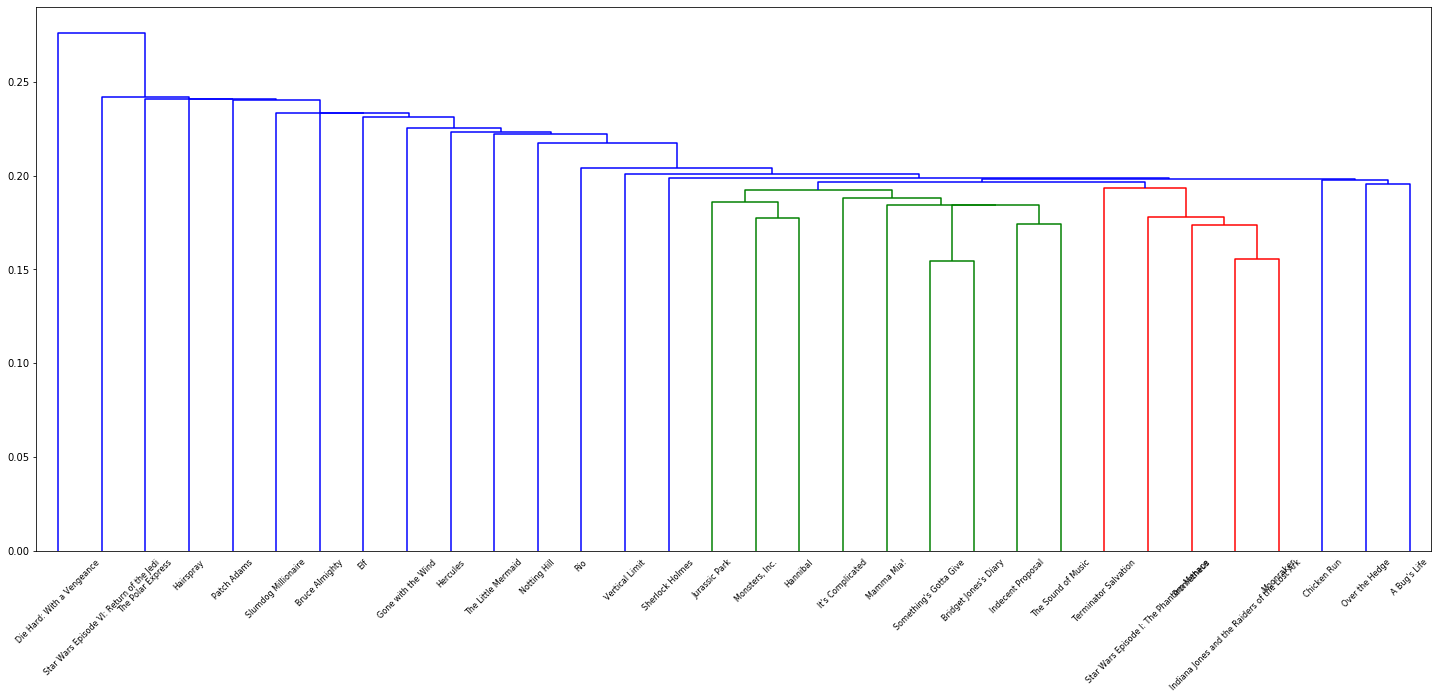

In [0]:
# Perform hierarchical clustering using single linkage
Z = hc.linkage(truncated_df[[x for x in truncated_df.columns if x.startswith('tfidf_')]], 'single')
fig = plt.figure(figsize=(25, 10))
dn = hc.dendrogram(Z, labels=truncated_df['Title'].values)
plt.show()

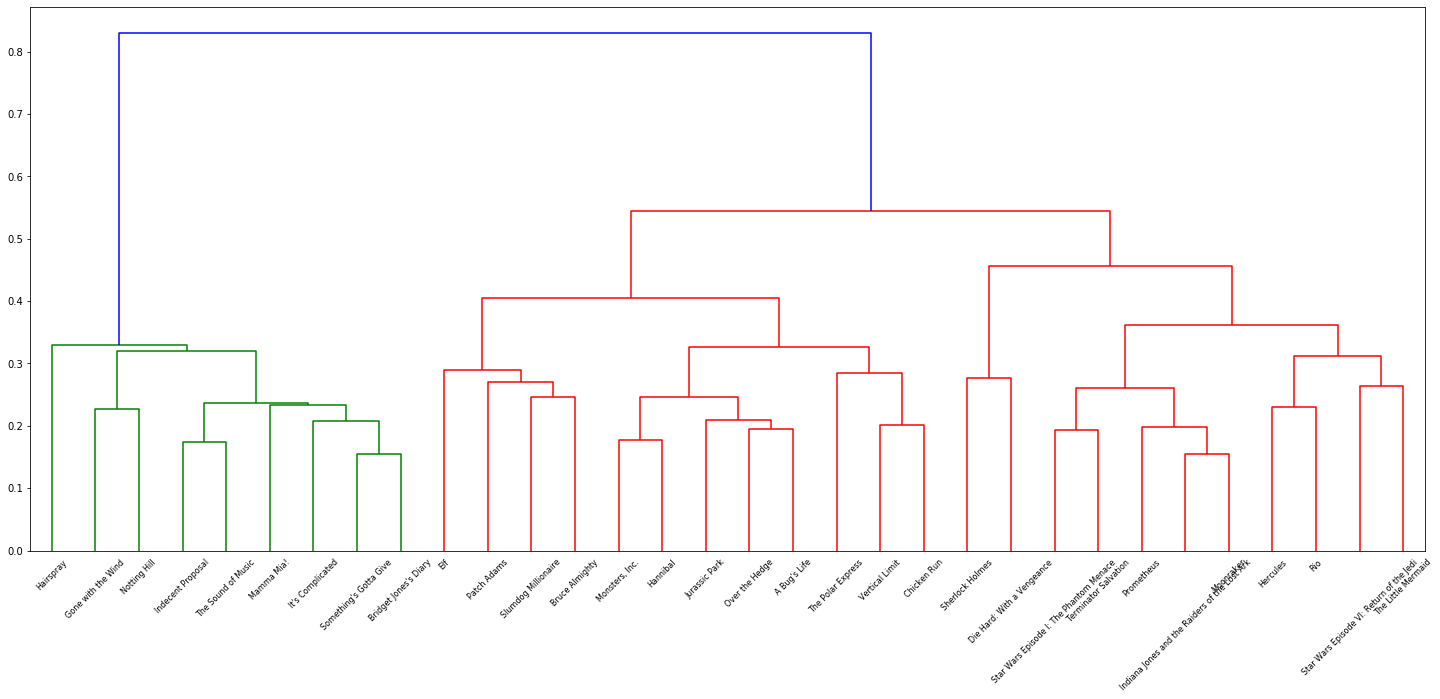

In [0]:
# # Perform hierarchical clustering using Ward linkage
Z = hc.linkage(truncated_df[[x for x in truncated_df.columns if x.startswith('tfidf_')]], 'ward')
fig = plt.figure(figsize=(25, 10))
dn = hc.dendrogram(Z, labels=truncated_df['Title'].values)
plt.show()



---



## Exercies

1. Perform hierarchical clustering using `complete`, `average`, `centroid` and plot dendograms.

    [SciPy Documentation on Hierarchical Clustering](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html)

In [0]:
# CODE HERE complete

In [0]:
# CODE HERE average

In [0]:
# CODE HERE centroid

2. Perform hierarchical clustering on the data using another distance metric. Is it better than `eucliedean` used above?

    [SciPy Documentation on distance metrics](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html)


In [0]:
# CODE HERE



---

### Book dataset

In [0]:
book_df = read_booksummaries()

3. Prepare `book_df` dataset:

* Extract TFIDF features from the `Summary` field
* Extract a sample of 32 books from the processed dataset.

In [0]:
# CODE HERE

4. Perform hierarchical clustering on the selected sample of books using 2 linkage methods and 2 distance metrics (4 total)

In [0]:
# CODE HERE

In [0]:
# CODE HERE

In [0]:
# CODE HERE

In [0]:
# CODE HERE